In [1]:
from tokeniser import Tokeniser
from load_text import load_prideandprejudice
import tensorflow as tf
import numpy as np
import sys
import os

/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-14 17:18:34.083298: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 17:18:34.107484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 17:18:34.575800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorR

# Create tokens

  0% (0 of 126) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (2 of 126) |                        | Elapsed Time: 0:00:00 ETA:   0:00:03
  3% (5 of 126) |                        | Elapsed Time: 0:00:00 ETA:   0:00:02
  6% (8 of 126) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:02


Loading tokeniser from 'vocab.json'...


  9% (12 of 126) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 11% (15 of 126) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 15% (20 of 126) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:01
 19% (24 of 126) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 22% (28 of 126) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:01
 25% (32 of 126) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:01
 29% (37 of 126) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:01
 33% (42 of 126) |#######                | Elapsed Time: 0:00:00 ETA:   0:00:01
 37% (47 of 126) |########               | Elapsed Time: 0:00:00 ETA:   0:00:01
 41% (52 of 126) |#########              | Elapsed Time: 0:00:00 ETA:   0:00:01
 46% (58 of 126) |##########             | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (63 of 126) |###########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (69 of 126) |############          

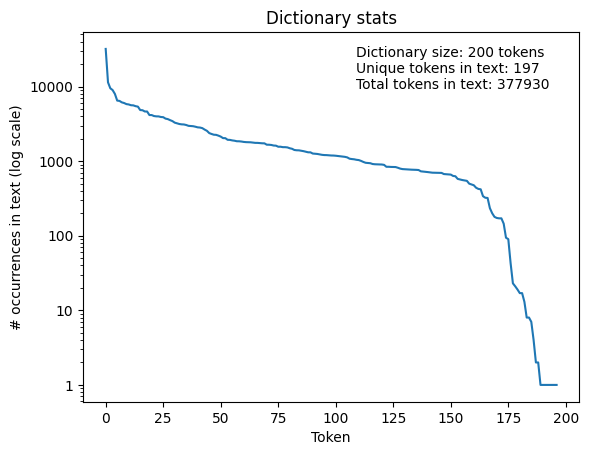

In [2]:
# Load text for training
text = load_prideandprejudice(max_words=1000)

vocab_size = 200 #Size of the vocabulary
filename = 'vocab.json'

# Load text
text = load_prideandprejudice()

# Check if tokeniser has been saved to disk
if os.path.exists(filename):
    # Load tokeniser from disk
    print("Loading tokeniser from '%s'..." % (filename))
    tokeniser = Tokeniser.load(filename)
else:
    # Create a new tokeniser, train it on the text and save it to disk
    tokeniser = Tokeniser(vocab_size=vocab_size)
    print("Building BPE tokeniser...")
    tokeniser.train(text, verbose=True)
    print("Saving tokeniser to '%s'..." % (filename))
    tokeniser.save(filename)

ids = tokeniser.encode(text, verbose=True)
tokeniser.plot(ids=ids)


In [3]:
len(ids)

377930

# Util functions

In [4]:
def onehot_to_id(onehot):
    return onehot.argmax()

def id_to_onehot(i, vocab_size):
    onehot = np.zeros(vocab_size)
    onehot[i] = 1
    return onehot

def id_to_token(i):
    return tokeniser.decode([i])

def token_to_id(token):
    return tokeniser.encode(token)

def onehot_to_token(onehot):
    return id_to_token(onehot_to_id(onehot))

def sequence_to_tokens(sequence):
    return [onehot_to_token(i) for i in sequence]    

# CBOW

In [5]:
# single hidden layer NN
# num inputs = num tokens
# num outputs = num tokens

# num neurons in hidden layer = desired embedding size
# window size number of surrounding words to consider

# yn = middle word, yn-1 = previous word, yn+1 = next word
# use one hot encoding for yn-1 and yn+1
# one input is the one hot encoding of a word + the one hot encoding of the previous word (or sum of one hot encodings of surrounding words)
# no bias

# the output we want is the one hot encoding of the middle word

# train beginning with random weights
# output cant be perfect always, we just want some kind of embedding

# weghts of the matrix from input to hidden layer are the embeddings

### Create A dataset
y is the target token

x is a list of sequences. each sequence is the sum of the onehot encoding of the n tokens on either side of the y. where n is the window size

In [6]:
onehot = [id_to_onehot(i, vocab_size) for i in ids]
window_size = 4

if window_size % 2 != 0:
    raise ValueError("window_size must be even")

sequences = []
x = []
y = []

for i in range(window_size//2, len(ids) - window_size//2):
    sequence = np.array(onehot[i - window_size // 2:i] + onehot[i+1:i + window_size // 2 + 1])
    sequences.append(sequence)
    x.append(sum(sequence))
    y.append(onehot[i])

x = np.array(x)
y = np.array(y)

# train test val split
n = len(x)
n_train = int(0.8 * n)
n_test = int(0.1 * n)
n_val = n - n_train - n_test

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:n_train + n_test]
y_test = y[n_train:n_train + n_test]

x_val = x[n_train + n_test:]
y_val = y[n_train + n_test:]

### Define the embedding layer

In [7]:
class Embedding(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units), 
            initializer='random_normal', 
            trainable=True)
        
    def get_embeddings(self):
        return self.w

    def call(self, inputs):
        return tf.nn.tanh(tf.matmul(inputs, self.w))

### Define and train the model
- input is a sequence
- output is a onehot encoded token
- we have one dense hidden layer with relu. the number of neurons is the number of dimensions of our vector embedding
- output layer with softmax. 

In [8]:
embedding_dimensions = 50 # mentioned 50-100 in skip gram paper

class tok2vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dimensions):
        super().__init__()
        self.embedding = Embedding(embedding_dimensions)
        self.dense = tf.keras.layers.Dense(vocab_size, activation='softmax')

    def get_embeddings(self):
        return self.embedding.get_embeddings()

    def call(self, inputs):
        x = self.embedding(inputs)
        return self.dense(x)

model = tok2vec(vocab_size, embedding_dimensions)

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(embedding_dimensions, activation='tanh'),
#     tf.keras.layers.Dense(vocab_size, activation='softmax')
# ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_info = model.fit(x_train, y_train, 
                       validation_data=(x_val, y_val),
                       epochs=10,
                       shuffle=True,
                       verbose=1)
model.summary()

2024-05-14 17:18:39.499099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 17:18:39.519415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 17:18:39.519519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/10
  99/9449 [..............................] - ETA: 9s - loss: 5.1974 - accuracy: 0.0710        

I0000 00:00:1715663926.276876  259965 service.cc:145] XLA service 0x7e6028dac6b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715663926.276895  259965 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-05-14 17:18:46.280134: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 17:18:46.288111: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1715663926.317941  259965 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9449/9449 [==============================] - 19s 1ms/step - loss: 3.4496 - accuracy: 0.2514 - val_loss: 3.0156 - val_accuracy: 0.3145
Epoch 2/10
9449/9449 [==============================] - 12s 1ms/step - loss: 2.9398 - accuracy: 0.3267 - val_loss: 2.8814 - val_accuracy: 0.3382
Epoch 3/10
9449/9449 [==============================] - 11s 1ms/step - loss: 2.8454 - accuracy: 0.3457 - val_loss: 2.8236 - val_accuracy: 0.3538
Epoch 4/10
9449/9449 [==============================] - 11s 1ms/step - loss: 2.7917 - accuracy: 0.3581 - val_loss: 2.7847 - val_accuracy: 0.3652
Epoch 5/10
9449/9449 [==============================] - 15s 2ms/step - loss: 2.7525 - accuracy: 0.3686 - val_loss: 2.7550 - val_accuracy: 0.3709
Epoch 6/10
9449/9449 [==============================] - 12s 1ms/step - loss: 2.7214 - accuracy: 0.3758 - val_loss: 2.7259 - val_accuracy: 0.3791
Epoch 7/10
9449/9449 [==============================] - 12s 1ms/step - loss: 2.6957 - accuracy: 0.3818 - val_loss: 2.7085 - val_accuracy: 0.3

### Get Embeddings and save them to file

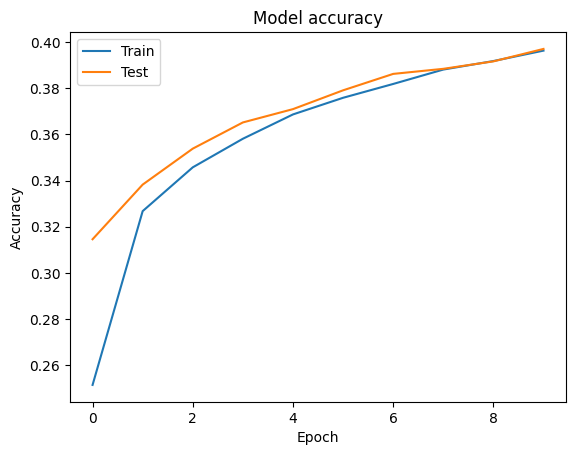

In [10]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(train_info.history['accuracy'])
plt.plot(train_info.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

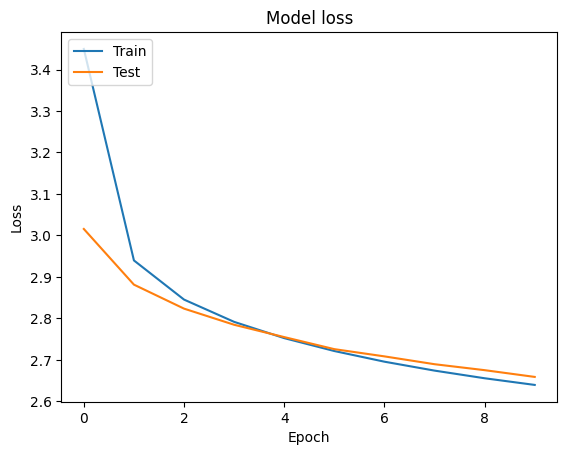

In [11]:
# plot loss
plt.plot(train_info.history['loss'])
plt.plot(train_info.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [9]:
embeddings = model.get_embeddings()
np.save('embeddings.npy', embeddings)